# Trajectory rollout with bounds and obstacles

In this example, we consider trajectory optimisation with infeasible regions - that is, we want to find a continuous path from an initial point to a target point, while avoiding obstacles in the way and staying within a well-defined region. 

To accomplish this, we chop up the path into discrete intervals and directly optimise over the intermediate values. Each step (in $x$) is given by $x_{k+1} = x_k + v_k$, and continuity is enforced by requiring that $x_{k+1} - (x_k + v_k) = 0$, which gives us our equality (continuity) constraints. 

This system can be described by four first-order ODEs, which is linear and time-invariant (LTI). It is given by

$$\dot{p} = Ap + Bu$$

where $p \in \mathbb{R}^4$ and $u \in \mathbb{R}^2$, and $p = [x, v_x, y, v_y]^T$. The control components represent acceleration and allow us to change the velocities $v_x, v_y$. 

To make sure that we stay well clear of the obstacles in our path we add a monotonically increasing function to their radius, such that we get a cylinder of increasing width and a constraint function 
$$c = \sqrt{(x_k - 1)^2 + (y_k - 1)^2} - 0.5 \cdot d(x) \geq 0$$
for each position $(x_k, y_k)$. 

And lastly, we want to do all of the above with velocities $v_x$ and $v_y$ in the range $\pm 0.2$. 

In [1]:
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optimistix as optx
from jaxtyping import Array


jax.config.update("jax_enable_x64", True)

### Setting up the LTI system

As a first step, let's describe the dynamical system - this is going to be the most
important part of our constraint function.

In [2]:
class LTISystem(eqx.Module):
    """Defines a simple linear time-invariant system of four first order ODEs with a
    forcing term u(t). The system evolves with

    dx = Ax + Bu.
    """

    A: Array
    B: Array

    def euler_step(self, states__inputs):  # Euler integration
        current_states, current_inputs = states__inputs
        return self.A @ current_states + self.B @ current_inputs


A = jnp.array([[1, 1, 0, 0], [0, 1, 0, 0], [0, 0, 1, 1], [0, 0, 0, 1]])
B = jnp.array([[0, 0], [1, 0], [0, 0], [0, 1]])
lti_system = LTISystem(A, B)

### Setting up the constraint function

Note that constraint functions can return a PyTree of values. In this case, each element in each leaf of the PyTree will be considered to represent the output of a constraint function. (In other words, each individual scalar value in taht PyTree represents one constraint.)

In [3]:
def make_constraint(system, initial_state, final_state, num_timepoints, centerpoint):
    def constraint(y):
        evolved_states = eqx.filter_vmap(system.euler_step, in_axes=eqx.if_array(0))(y)

        xs, _ = y
        starting_point = xs[0, :] - initial_state
        continuity = xs[1:, :] - evolved_states[:-1, :]
        target_reached = evolved_states[-1, :] - final_state

        equality_constraints = (starting_point, continuity, target_reached)

        # TODO: these are technically bounds
        lower_v1 = 0.2 - xs[:, 1]  # v1 < 0.2
        upper_v1 = 0.2 + xs[:, 1]  # v1 > -0.2
        lower_v3 = 0.2 - xs[:, 3]  # v3 < 0.2
        upper_v3 = 0.2 + xs[:, 3]  # v3 > -0.2
        speed_limit = (lower_v1, upper_v1, lower_v3, upper_v3)

        augmented_radius = 1 + jnp.array([i * 0.1 for i in range(num_timepoints)])
        x_center, y_center = centerpoint
        x_distance = (xs[:, 0] - x_center) ** 2
        y_distance = (xs[:, 2] - y_center) ** 2
        distance = jnp.sqrt(x_distance + y_distance) - 0.5 * augmented_radius

        return equality_constraints, (speed_limit, distance)

    return constraint


num_timepoints = 20
x0 = jnp.array([2.0, 0.0, 2.0, 0.0])
centerpoint = (1.0, 1.0)
constraint = make_constraint(
    system=lti_system,
    initial_state=x0,
    final_state=jnp.zeros(4),
    num_timepoints=num_timepoints,
    centerpoint=centerpoint,
)

Now, since we want to optimise - we are going to need an objective function!

In this case we want to minimise the distance to the center of the obstacle and also
avoid high velocities. Additionally, we only want to exercise as much control as is
absolutely necessary. All deviations are going to carry a quadratic cost.

And last but not least, we need a starting point `y0`.

In [4]:
def objective(states__inputs, args):
    states, inputs = states__inputs
    state_cost, control_cost = args

    x_position = states[:, 0]
    y_position = states[:, 2]
    distance = jnp.sum(x_position**2 + y_position**2)

    x_velocity = states[:, 1]
    y_velocity = states[:, 3]
    velocities = jnp.sum(x_velocity**2 + y_velocity**2)

    spatial_component = state_cost * (distance + velocities)
    control_component = control_cost * jnp.sum(inputs**2)

    return spatial_component + control_component


# Define costs and some starting point y0
costs = (10.0, 1.0)
states = jnp.broadcast_to(jnp.array([2.0, 0.0, 2.1, 0.0]), (num_timepoints, 4))
inputs = jnp.zeros((num_timepoints, 2))
y0 = (states, inputs)

Now, let's solve the problem!

In [5]:
solver = optx.IPOPTLike(rtol=0, atol=1e-3)
descent = optx.NewInteriorDescent()
search = optx.LearningRate(1.0)
solver = eqx.tree_at(lambda s: s.descent, solver, descent)
solver = eqx.tree_at(lambda s: s.search, solver, search)

solution = optx.minimise(
    objective,
    solver,
    y0,
    costs,
    constraint=constraint,
    throw=False,
)

print(solver)
solution.stats["num_steps"], solution.result == optx.RESULTS.successful

IPOPTLike(
  rtol=0,
  atol=0.001,
  norm=<function max_norm>,
  descent=NewInteriorDescent(linear_solver=SVD()),
  search=LearningRate(learning_rate=weak_f64[]),
  verbose=frozenset({}),
  initial_barrier_parameter=0.1
)


(Array(101, dtype=int64, weak_type=True), Array(True, dtype=bool))

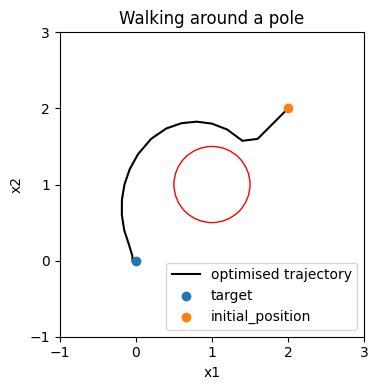

In [6]:
from matplotlib.patches import Circle


fig, ax = plt.subplots(1, 1, figsize=(4, 4))

final_states, final_inputs = solution.value
x_positions = final_states[:, 0]
y_positions = final_states[:, 2]
ax.plot(x_positions, y_positions, "k-", label="optimised trajectory")
ax.scatter(0, 0, label="target", zorder=2)
ax.scatter(2, 2, label="initial_position", zorder=2)

circle = Circle(centerpoint, 0.5, color="r", fill=False)
ax.add_artist(circle)

limits = (-1, 3)
ticks = [-1, 0, 1, 2, 3]
ax.set_xlim(limits)
ax.set_ylim(limits)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_aspect("equal")

ax.set_title("Walking around a pole")

ax.legend(loc="lower right")
fig.tight_layout()

Text(0.5, 1.0, 'Search: learning rate')

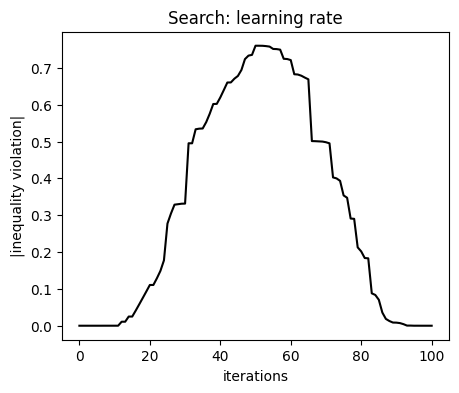

In [7]:
inequality_violation = [
    0.0,
    2.538019211462128e-07,
    3.2123988649157553e-06,
    3.3242408797318213e-06,
    4.118132071878611e-06,
    4.827024974646266e-06,
    5.0785033801539065e-06,
    4.857069483178711e-05,
    4.855419464712754e-05,
    4.855535079607842e-05,
    4.849133370244188e-05,
    4.8401555345087624e-05,
    0.01089343886537233,
    0.010891461040230345,
    0.024883871415540285,
    0.02488211926388505,
    0.041262992136224266,
    0.05829087499055601,
    0.07555251251753478,
    0.09297895787222885,
    0.1106301397507009,
    0.11062157086079774,
    0.12878423373486805,
    0.14884342380423382,
    0.17741887778405557,
    0.27731306097493413,
    0.3047485145255063,
    0.3286675199586122,
    0.3298953606589177,
    0.3312256992453309,
    0.3315311299507481,
    0.4953589252978203,
    0.49526340043751604,
    0.5333025922302055,
    0.5349915605406534,
    0.5354732912704739,
    0.5527139407731957,
    0.5755665793730976,
    0.601931835039688,
    0.6022932377613446,
    0.6197725784187668,
    0.639876128616199,
    0.6602901484242799,
    0.66050031179593,
    0.6706544517337084,
    0.6781099571006822,
    0.694389678927883,
    0.7238256125935065,
    0.7332563673987447,
    0.7353867066525432,
    0.7601683883496038,
    0.760132105530824,
    0.7599685344594806,
    0.7591171140969808,
    0.7577575504937141,
    0.7514163105707912,
    0.7510025133266622,
    0.7494689108437765,
    0.7246946731514995,
    0.7240347345482581,
    0.721166738964504,
    0.6827593165404015,
    0.6820137526198983,
    0.6787504229230819,
    0.6736225449518705,
    0.6689376256761282,
    0.5012999376263987,
    0.500978026620042,
    0.5004445737400157,
    0.49994850659580464,
    0.49812800856403067,
    0.4951615481897072,
    0.4026248058864153,
    0.39996918331036946,
    0.39331044904301626,
    0.35376383447082876,
    0.34738798219252054,
    0.29098105088245707,
    0.2901926501045825,
    0.2127299959288866,
    0.20171419622667786,
    0.18378960221776408,
    0.18297257645500312,
    0.08794654963976278,
    0.08352082404173716,
    0.07040759739813089,
    0.035724185250862024,
    0.018501047559648834,
    0.012728965972827258,
    0.008621274859197024,
    0.008365955256291059,
    0.007132520085565992,
    0.0042343314711628215,
    0.0003542295421924621,
    0.00037651211690468804,
    2.6650449662811784e-05,
    5.2706342937992694e-05,
    3.0486134599068578e-06,
    2.9738930683062374e-06,
    3.585224753611515e-08,
    1.1719690840082501e-10,
]


fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(jnp.arange(len(inequality_violation)), inequality_violation, "k-")
ax.set_xlabel("iterations")
ax.set_ylabel("|inequality violation|")
ax.set_title("Search: learning rate")

Text(0.5, 1.0, 'Search: learning rate')

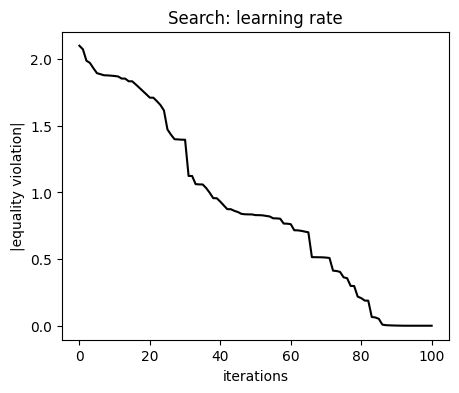

In [8]:
equality_violation = [
    2.1,
    2.07321805066895,
    1.987577983097774,
    1.9706902777779547,
    1.9302604957906861,
    1.8940121427067385,
    1.8863291727686213,
    1.8783389530688743,
    1.8774517288727068,
    1.8754232504241712,
    1.8729497284033718,
    1.8692711331192418,
    1.8536130225586342,
    1.853276488347618,
    1.8332302275744596,
    1.833101144069193,
    1.809619169155628,
    1.7852176690601602,
    1.760490170798948,
    1.735536435121724,
    1.7102717079026168,
    1.710139238680862,
    1.6841422649232323,
    1.6554453776717122,
    1.614589439755265,
    1.4718716654235084,
    1.4328677273506811,
    1.3989253408565603,
    1.397186530403985,
    1.3953027900675887,
    1.3948703648344871,
    1.12329684805125,
    1.1230802323043836,
    1.061968960939222,
    1.0599300326539323,
    1.059348920583263,
    1.0322756541324851,
    0.9967765768988328,
    0.956579788633199,
    0.9562057979087056,
    0.9305559954494443,
    0.9018747060674757,
    0.87392419755645,
    0.8737720801648212,
    0.8613298760330086,
    0.8527619002468059,
    0.8389784807509884,
    0.8358061818438285,
    0.8350311802314976,
    0.8346751966013896,
    0.82950744255524,
    0.8291902085492648,
    0.8279407179927545,
    0.823481458469689,
    0.8197004151523778,
    0.8056569322446048,
    0.8050259293128028,
    0.8027032560386237,
    0.7660647329077794,
    0.7652718861310891,
    0.76183109519122,
    0.7160446544297583,
    0.7152078532332987,
    0.7115470456282089,
    0.7058097312771081,
    0.7005871695143415,
    0.5143074888893416,
    0.5139772244579436,
    0.5134299297342495,
    0.5129209908180129,
    0.5110532551573974,
    0.5080098221351073,
    0.4130719696901348,
    0.41034743997363077,
    0.403515927261922,
    0.3629431713437238,
    0.35640188074125556,
    0.2985313226456314,
    0.2977224647276254,
    0.2183055138332996,
    0.2070009970265645,
    0.18862233245707033,
    0.18778382307866254,
    0.06538159249091557,
    0.06208559685772008,
    0.05180810248379503,
    0.008206268711646064,
    0.004157659955269261,
    0.0028469436338177945,
    0.0019156813968569109,
    0.0011008537333220547,
    0.0006428978882323522,
    0.00011868682769620997,
    4.294925526338034e-12,
    1.1353593065699386e-10,
    1.847350050709906e-11,
    1.0489381585543356e-10,
    5.239229883269303e-11,
    4.544276066553721e-11,
    8.790285374593587e-10,
    9.355294317003882e-12,
]

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(jnp.arange(len(equality_violation)), equality_violation, "k-")
ax.set_xlabel("iterations")
ax.set_ylabel("|equality violation|")
ax.set_title("Search: learning rate")